## Course Reccomendation System 

In [532]:
from __future__ import annotations # To prevent Subscript for class "list" will generate runtime exception; enclose type annotation in quotes
import seaborn as sns
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import scipy
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

### KMeans algorithm

In [533]:
def eucledian_distance(x1,x2) :
  return np.sqrt(np.sum((x1-x2)**2)) #vector based

def minkowski_distance(x1,x2,p):
  from scipy.spatial import distance
  return distance.minkowski(x1,x2,p)

class Kmeans:
  #K = number of clusters
  #iter = number of iterations
  def __init__(self,K,iter,p):
    self.K=K
    self.iter=iter
    self.p=p
    #Initialising empty K clusters -> storing indicies
    self.clusters = [[] for _ in range(self.K)] 
    #storing centroids 
    self.centroids=[]
    self.inertia = 0.0 

  def plus_plus(self,ds:np.array, k, random_state=1000):
    """
    Create cluster centroids using the k-means++ algorithm.
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    Inspiration from here: https://stackoverflow.com/questions/5466323/how-could-one-implement-the-k-means-algorithm
    """

    np.random.seed(random_state)
    centroids = [ds[0]]

    for _ in range(1, k):
        dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
        probs = dist_sq/dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        
        centroids.append(ds[i])

    return np.array(centroids)

  def predict(self,X,choice=0): #no fit required for unsupervised learning models
    self.X=X
    self.n_samples,self.n_features = X.shape #numpy N-d array
    
    #initialise centroids
    if choice == 0:
        centroids = np.zeros((self.K, self.n_features)) # row , column full with zero 
        for k in range(self.K): # iterations of 
            centroid = X[np.random.choice(range(self.n_samples))] # random centroids
            centroids[k] = centroid
        self.centroids = centroids
    elif choice == 1:
      self.centroids=self.plus_plus(X,self.K)

    elif choice == 2:
      self.centroids=self.naive_sharding(X,self.K)
    

    #optimise 
    for _ in range(self.iter):
      #update clusters
      self.clusters=self._create_clusters(self.centroids)
      #update centroids 
      centroids_old = self.centroids #for convergence test 
      self.centroids = self._get_centroids(self.clusters)
       #get cetnroids assign mean value of cluster to the centroid
      #check for convergence
      if self._isConverged(centroids_old,self.centroids):
        break

      #break 
    #classify the samples based on index of cluster
    labels = self.getClusterLabels(self.clusters)
    self.calculateInertia(X,labels)
    return labels
    #return cluster labels 
  def _create_clusters(self,centroids):
    clusters = [[] for _ in range(self.K)]
    for idx,sample in enumerate(self.X):
      #find the closest centroid to classify, then put it in the specific cluster
      #here cluster is an list of list 
      centroid_idx = self._closest_centroid(sample,centroids)
      clusters[centroid_idx].append(idx)
    return clusters
  def function (self,point):
    return minkowski_distance(self.sample, point, self.p)

  def _closest_centroid(self,sample,centroids):
    #distance metric  
    distances = [minkowski_distance(sample,point,self.p) for point in centroids]
    #argmin for required parameters
    closest_idx = np.argmin(distances)
    # self.sample=sample
    # closest_idx = scipy.optimize.minimize (fun=function ,x0=np.asarray(centroids))
    return closest_idx
  def _get_centroids(self,clusters):
    centroids = np.zeros((self.K,self.n_features)) #Dimension = N as N = number of features
    for cluster_idx, cluster in enumerate(clusters):
      #calling mean on a specific current cluster as X is array of various clusters
      if(len(cluster)!=0):
        cluster_mean = np.mean(self.X[cluster],axis = 0)
        centroids[cluster_idx] = cluster_mean #set mean as newer centroids
    return centroids 
  def _isConverged(self,centroids_old,centroids):
    distances = [minkowski_distance(centroids_old[i],centroids[i],self.p) for i in range(self.K)]
    return sum(distances)==0 #no more change occured in 2 iteration so converges 

  def getClusterLabels(self,clusters):
    labels = np.empty(self.n_samples)
    for cluster_idx,cluster in enumerate(clusters):
      for sample_idx in cluster:
        labels[sample_idx] = cluster_idx
    return labels 
  
  def calculateInertia(self,datapoints: list[int],labels: list[any])->None:
    labels = labels.astype(int)
    for idx,pts in enumerate(datapoints):
      self.inertia += minkowski_distance(self.centroids[labels[idx]],pts,2)**2

### Testing on generated datapoints

In [534]:
df=pd.read_excel('Course Recommendation System.xlsx')
df=df.drop(['ID','Start time','Completion time','Email','Name','Name(not mandatory)\n' ], axis=1).fillna(0.5)
df

,Data Structures and Algorithms,Computer Architecture\n,Discrete Mathematics\n,Economics,Programming-2,Machine Learning\n,Mathematics For Machine Learning\n,Visual Recognition\n,Natural Language Processing\n,Reinforcement Learning,...,Digital CMOS VLSI Design,System design with FPGA,ASIC design,VLSI Architecture Design\n,High level synthesis and optimization of Digital Circuits,Digital Sociology,Privacy in the Digital Age,Technology Ethics and AI,Techno-economics of networks,The Web and the Mind
0,0.30,0.85,0.85,0.90,0.70,0.70,0.80,0.50,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.6,0.5,0.5,0.5
1,0.70,0.80,0.20,0.80,0.80,0.50,0.10,0.20,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0.70,0.00,1.00,1.00,1.00,1.00,1.00,0.80,0.9,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.4,0.5,0.5,0.5
3,0.65,0.70,0.20,0.75,0.75,0.75,0.75,0.75,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.8,0.5,0.5,0.8,0.5
4,0.70,0.60,0.20,0.00,0.80,0.50,0.60,0.40,0.4,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.00,1.00,0.50,0.70,0.60,0.50,0.30,0.70,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5
158,1.00,0.00,0.00,0.70,0.70,0.00,0.00,0.00,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.2
159,0.60,0.30,0.40,0.90,0.80,0.70,0.40,0.50,0.4,0.2,...,0.5,0.5,0.5,0.5,0.5,0.5,1.0,0.5,0.5,1.0
160,0.80,0.60,0.20,0.40,0.70,0.70,0.80,0.50,0.5,0.7,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [535]:
df=df[[df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[4]]]
df

,Data Structures and Algorithms,Computer Architecture\n,Discrete Mathematics\n,Economics,Programming-2
0,0.30,0.85,0.85,0.90,0.70
1,0.70,0.80,0.20,0.80,0.80
2,0.70,0.00,1.00,1.00,1.00
3,0.65,0.70,0.20,0.75,0.75
4,0.70,0.60,0.20,0.00,0.80
...,...,...,...,...,...
157,0.00,1.00,0.50,0.70,0.60
158,1.00,0.00,0.00,0.70,0.70
159,0.60,0.30,0.40,0.90,0.80
160,0.80,0.60,0.20,0.40,0.70


#### Trial Run 

In [536]:
k=Kmeans(K=29,iter=150,p=2)
y_pred=k.predict(np.array(df),choice=0)
k.centroids=np.array(k.centroids, dtype='int')
len(k.centroids)
y_pred

array([19.,  4., 17., 25.,  7., 13., 14.,  0., 13.,  6., 18., 13., 12.,
       13., 13., 26., 13., 19., 13., 18., 25., 13.,  1., 21., 21., 13.,
        0., 26.,  7., 10., 25., 13.,  7., 19., 13., 22., 13., 13., 14.,
       18.,  0., 19.,  1., 13.,  0., 21., 13.,  7., 15.,  0.,  4., 18.,
       14., 21., 12.,  4., 20., 13., 18.,  9.,  0.,  0., 21.,  9., 25.,
       18., 14.,  1., 13., 26., 19.,  1., 26., 14.,  4.,  4., 13., 18.,
        4.,  8.,  7., 13.,  6., 14.,  7., 18., 15.,  9., 15.,  7., 14.,
        7., 18.,  0.,  3.,  2., 21.,  4., 26.,  0.,  8., 26.,  1., 13.,
       20., 14., 13.,  9., 20.,  2., 14.,  7., 13., 21.,  1., 20., 13.,
       19., 20., 21.,  7., 21.,  8., 14., 21., 12., 12.,  5., 13., 21.,
       18., 13., 22., 21., 20., 22., 26., 21., 21., 21., 14., 18.,  7.,
       17., 18.,  9.,  3.,  4., 13., 21., 21., 22., 26., 26.,  1.,  6.,
       17., 15.,  1.,  0., 25.,  5.])

#### Elbow plot: Our implementation 

In [537]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = Kmeans(K=k,iter=150,p=2)
    kmeanModel.predict(np.array(df),choice=1)
    distortions.append(kmeanModel.inertia)

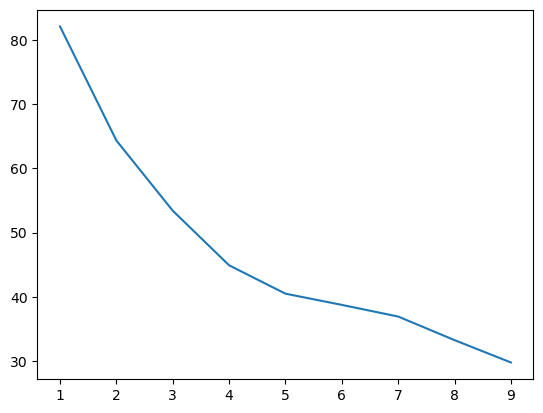

In [538]:
plt.plot(K,distortions)

### SKlearn Comparision 

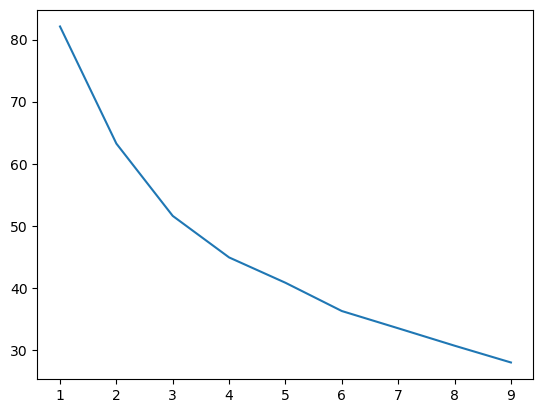

In [539]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
core_courses = ['Data Structures and Algorithms','Computer Architecture\n','Discrete Mathematics\n','Economics','Programming-2']
wcss = []  #Within Cluster Sum of Squares
for number_of_clusters in range(1, 10): 
    kmeans = KMeans(n_clusters = number_of_clusters, random_state = 42,init='random')
    kmeans.fit(df) 
    wcss.append(kmeans.inertia_)
    # print(kmeans.n_iter_)
ks = [x for x in range(1,10)]
plt.plot(ks, wcss)

In [540]:
distortions

[82.11226015529861,
 64.34069735843698,
 53.40007705800851,
 44.89006011022395,
 40.46880616557636,
 38.7225800340446,
 36.90427502199772,
 33.229013950847936,
 29.7468977651558]

In [541]:
wcss

[82.11226015529861,
 63.24078648485308,
 51.58991760241395,
 44.89950583242211,
 40.815556917228335,
 36.262752708925674,
 33.48422395110803,
 30.679086316240635,
 27.97433851426379]

#### Applying Pre-processing steps on data: 


In [542]:
df=pd.read_excel('Course Recommendation System.xlsx')
df=df.drop(['ID','Start time','Completion time','Email','Name','Name(not mandatory)\n' ], axis=1) 
df 

,Data Structures and Algorithms,Computer Architecture\n,Discrete Mathematics\n,Economics,Programming-2,Machine Learning\n,Mathematics For Machine Learning\n,Visual Recognition\n,Natural Language Processing\n,Reinforcement Learning,...,Digital CMOS VLSI Design,System design with FPGA,ASIC design,VLSI Architecture Design\n,High level synthesis and optimization of Digital Circuits,Digital Sociology,Privacy in the Digital Age,Technology Ethics and AI,Techno-economics of networks,The Web and the Mind
0,0.30,0.85,0.85,0.90,0.70,0.70,0.80,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.6,NaN,NaN,NaN
1,0.70,0.80,0.20,0.80,0.80,0.50,0.10,0.20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN
2,0.70,0.00,1.00,1.00,1.00,1.00,1.00,0.80,0.9,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN
3,0.65,0.70,0.20,0.75,0.75,0.75,0.75,0.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.8,NaN,NaN,0.8,NaN
4,0.70,0.60,0.20,0.00,0.80,0.50,0.60,0.40,0.4,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.00,1.00,0.50,0.70,0.60,0.50,0.30,0.70,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
158,1.00,0.00,0.00,0.70,0.70,0.00,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2
159,0.60,0.30,0.40,0.90,0.80,0.70,0.40,0.50,0.4,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0
160,0.80,0.60,0.20,0.40,0.70,0.70,0.80,NaN,NaN,0.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [543]:
df_cluster=df[[df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[4]]]
df_cluster

,Data Structures and Algorithms,Computer Architecture\n,Discrete Mathematics\n,Economics,Programming-2
0,0.30,0.85,0.85,0.90,0.70
1,0.70,0.80,0.20,0.80,0.80
2,0.70,0.00,1.00,1.00,1.00
3,0.65,0.70,0.20,0.75,0.75
4,0.70,0.60,0.20,0.00,0.80
...,...,...,...,...,...
157,0.00,1.00,0.50,0.70,0.60
158,1.00,0.00,0.00,0.70,0.70
159,0.60,0.30,0.40,0.90,0.80
160,0.80,0.60,0.20,0.40,0.70


In [544]:
num_cluster = 4 

In [545]:
k=Kmeans(K=num_cluster,iter=150,p=2)
y_pred=k.predict(np.array(df_cluster),choice=0)
k.centroids=np.array(k.centroids, dtype='int')
len(k.centroids)
y_pred

array([3., 1., 3., 1., 1., 3., 2., 1., 3., 2., 3., 3., 2., 3., 3., 1., 3.,
       3., 3., 3., 1., 3., 1., 3., 3., 3., 1., 1., 2., 1., 1., 3., 2., 3.,
       3., 1., 0., 3., 2., 2., 1., 3., 1., 3., 1., 3., 3., 2., 1., 1., 1.,
       3., 2., 3., 3., 1., 2., 3., 3., 1., 1., 1., 3., 3., 1., 3., 2., 1.,
       3., 3., 3., 1., 3., 2., 1., 1., 3., 3., 1., 0., 2., 3., 0., 2., 1.,
       3., 0., 3., 0., 1., 2., 2., 3., 1., 2., 0., 3., 3., 1., 1., 0., 2.,
       1., 3., 2., 2., 0., 3., 2., 0., 2., 1., 0., 3., 1., 2., 3., 3., 2.,
       3., 1., 3., 0., 2., 3., 3., 2., 0., 3., 3., 3., 3., 1., 3., 2., 2.,
       2., 3., 3., 3., 2., 3., 1., 3., 3., 3., 2., 3., 3., 3., 3., 1., 1.,
       3., 1., 0., 3., 0., 1., 1., 1., 0.])

In [546]:
df = pd.concat([df,pd.DataFrame(y_pred,columns=["label"],dtype='int')],axis="columns")

In [547]:
df

,Data Structures and Algorithms,Computer Architecture\n,Discrete Mathematics\n,Economics,Programming-2,Machine Learning\n,Mathematics For Machine Learning\n,Visual Recognition\n,Natural Language Processing\n,Reinforcement Learning,...,System design with FPGA,ASIC design,VLSI Architecture Design\n,High level synthesis and optimization of Digital Circuits,Digital Sociology,Privacy in the Digital Age,Technology Ethics and AI,Techno-economics of networks,The Web and the Mind,label
0,0.30,0.85,0.85,0.90,0.70,0.70,0.80,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.6,NaN,NaN,NaN,3
1,0.70,0.80,0.20,0.80,0.80,0.50,0.10,0.20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,1
2,0.70,0.00,1.00,1.00,1.00,1.00,1.00,0.80,0.9,1.0,...,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,3
3,0.65,0.70,0.20,0.75,0.75,0.75,0.75,0.75,NaN,NaN,...,NaN,NaN,NaN,NaN,0.8,NaN,NaN,0.8,NaN,1
4,0.70,0.60,0.20,0.00,0.80,0.50,0.60,0.40,0.4,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.00,1.00,0.50,0.70,0.60,0.50,0.30,0.70,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
158,1.00,0.00,0.00,0.70,0.70,0.00,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,1
159,0.60,0.30,0.40,0.90,0.80,0.70,0.40,0.50,0.4,0.2,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1
160,0.80,0.60,0.20,0.40,0.70,0.70,0.80,NaN,NaN,0.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [567]:
df_cluster_rep = df.groupby(['label'], as_index=False).mean()

In [571]:
df_cluster_rep.drop(labels="label",axis="columns",inplace=True)

In [573]:
print((df_cluster_rep == 0).any().any())

False


In [575]:
matrix = df_cluster_rep.to_numpy()
matrix

(4, 25)

In [576]:
matrix.shape

(4, 25)

In [586]:
from SVD import * 

u,s,sigma,V_trans = SVD(matrix)


ValueError: shapes (4,4) and (25,4) not aligned: 4 (dim 1) != 25 (dim 0)